## 基于Bert实现知识库问答

- **任务描述：** 基于知识库的问答来讨论问答系统
  - 知识库问答也叫做知识图谱问答，模型结合知识图谱，对输入的问题进行推理和查询从而得到正确答案的一项综合性任务。
  - 知识图谱问答方法可分为两大类：
    - **基于信息检索**
      - 信息检索的方式不需要生成中间结果，直接得到问题答案，十分简洁，但是对复杂问题的处理能力有限
    - **基于语义解析**
      - 语义解析的方式需要对输入的自然语言问题进行语义解析，再进行推理，具备解决复杂问题的能力
      
- **方法概述**：
  - 利用深度学习工具pytorch，利用Bert模型实现知识库问答系统
  - 通过加载数据、预处理数据、构建模型、训练模型、测试用例依次实现一个知识库问答工具，在训练和预处理过程中通过可视化监督训练过程

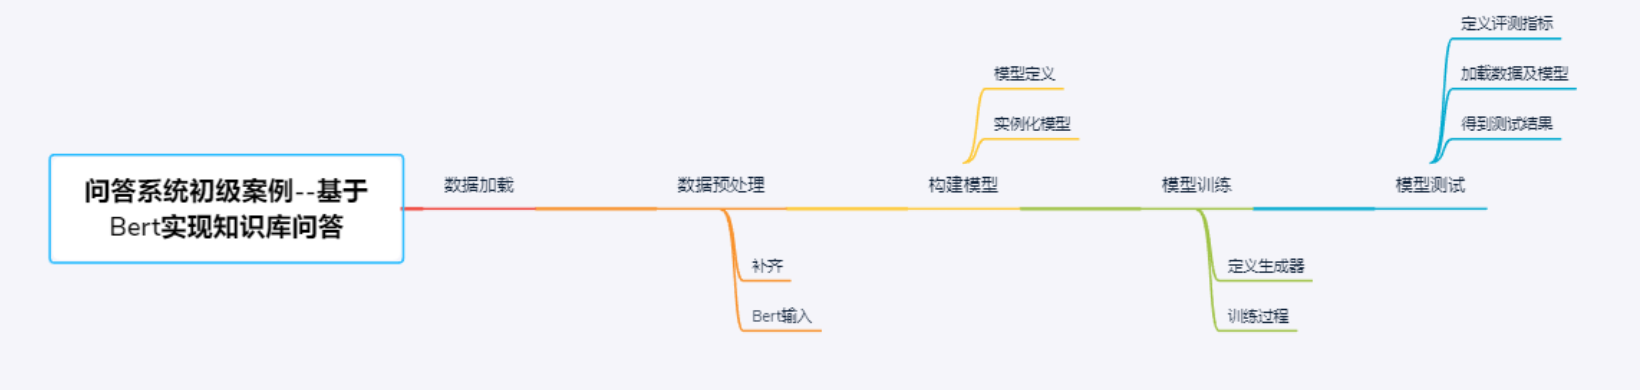

In [1]:
import pandas as pd
import numpy as np
import csv
import transformers
import torch
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from transformers import BertPreTrainedModel,BertModel
from torch import nn

import warnings
warnings.filterwarnings('ignore')

In [2]:
kagging = True

#### 数据准备
##### 数据说明
- QuestionID: 问题id
- Question: 问题文本
- DocumentID: 检索到的作为答案来源的文档ID
- Document: 检索到的作为答案来源的文档标题
- SentenceID: 对于文档摘要中的每个句子的id
- Sentence: 文档中摘要中的句子
- label: 判断句子是否是答案的标签

In [4]:
pd_table = pd.read_csv('./dataset/WikiQA-train.tsv',encoding="utf-8",sep='\t')

In [5]:
pd_table.shape

(20347, 7)

In [7]:
pd_table.head()

,QuestionID,Question,DocumentID,DocumentTitle,SentenceID,Sentence,Label
0,Q1,how are glacier caves formed?,D1,Glacier cave,D1-0,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,D1,Glacier cave,D1-1,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,D1,Glacier cave,D1-2,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,D1,Glacier cave,D1-3,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,D1,Glacier cave,D1-4,"Glacier caves are often called ice caves , but...",0


##### 数据加载
- 定义load函数。使用csv将文件读入，在csv.reader中指定'\t'作为分隔符（delimiter），将数据自动分割。
- 依次遍历每一行，将数据按照上述数据结构加载

In [8]:
def load(filename):
    result = []
    with open(filename,'r',encoding='utf-8') as csvfile:
        spamreader = csv.reader(csvfile,delimiter='\t',quotechar='"')
        next(spamreader, None) #跳过标题行
        for row in spamreader:
            res ={}
            res['question'] = str(row[1])
            res['answer'] = str(row[5])
            res['label'] = int(row[6])
            result.append(res)
    return result

In [9]:
train_file = load('./dataset/WikiQA-train.tsv')
valid_file = load('./dataset/WikiQA-dev.tsv')
test_file = load('./dataset/WikiQA-test.tsv')

In [11]:
test_file[0]

{'question': 'HOW AFRICAN AMERICANS WERE IMMIGRATED TO THE US',
 'answer': 'African immigration to the United States refers to immigrants to the United States who are or were nationals of Africa .',
 'label': 0}

In [12]:
print(len(train_file))
print(len(valid_file))
print(len(test_file))

20347
2733
6116


In [13]:
if kagging:
    train_file = train_file[:int(len(train_file)*0.01)]
    valid_file = valid_file[:int(len(valid_file)*0.01)]
    test_file = test_file[:int(len(test_file)*0.01)]
    print(len(train_file))
    print(len(valid_file))
    print(len(test_file))

203
27
61


In [14]:
train_file[:10]

[{'question': 'how are glacier caves formed?',
  'answer': 'A partly submerged glacier cave on Perito Moreno Glacier .',
  'label': 0},
 {'question': 'how are glacier caves formed?',
  'answer': 'The ice facade is approximately 60 m high',
  'label': 0},
 {'question': 'how are glacier caves formed?',
  'answer': 'Ice formations in the Titlis glacier cave',
  'label': 0},
 {'question': 'how are glacier caves formed?',
  'answer': 'A glacier cave is a cave formed within the ice of a glacier .',
  'label': 1},
 {'question': 'how are glacier caves formed?',
  'answer': 'Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.',
  'label': 0},
 {'question': 'How are the directions of the velocity and force vectors related in a circular motion',
  'answer': 'In physics , circular motion is a movement of an object along the circumference of a circle or rotation along a circular path.',
  'label': 0},
 {'question': 'How ar

#### 数据标准化

##### 数据补齐

In [15]:
# 数据补齐
def padding(sequence,max_length,pad_token=0):
    padding_length = max_length - len(sequence)
    return sequence + [pad_token] * padding_length

##### Bert的标准输入
- Bert的输入主要由input_ids,input_mask,token_type_ids三部分构成
  - input_ids:Bert的输入通常需要两个句子，句子A前由[CLS]开始，以[SEP]结束，后面再连接句子B的向量，之后再将上述句子根据词表转化为one-hot向量，作为Bert的输入input_ids; 如：
    - [CLS] how are glacier caves formed [SEP] A partly submerged glacier cave on Perito Moreno Glacier [SEP]
  - input_mask: 由于不同批次的数据长度不同，因此会对数据进行补全。但补全的信息对于网络是无用的，不应该对模型产生影响，因此通过掩码将其标注出来，便于训练
  - token_type_ids:用于标记一个input_ids序列中哪些位置是第一句话，哪些位置是第二句话

- 用transformer中的BertTokenizer进行处理。
  - tokenizer需要指定预训练模型位置，读取使用的词表vocab用于文本转换。
  - 使用tokenizer的encode_plus方法，除了可以对文本进行分词外，还可以将输入序列转换为上述的标准形式。
  - max_length指定序列的最长长度，如果输入的序列过长会进行截断。
  - add_special_tokens 设为True就可以将句子转化成对应模型的输入形式。

In [25]:
model_path = "./models/bert-pretrain/"
tokenizer = transformers.BertTokenizer.from_pretrained(model_path,do_lower_case=True)
# max_length = 512
max_length = 64

#如果使用cpu ,则使用
# device = torch.device('cpu')

#如果使用gpu ,则使用
device =torch.device('cuda:0')

In [20]:
tokenizer

PreTrainedTokenizer(name_or_path='./models/bert-pretrain/', vocab_size=30522, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [31]:
def tokenize(data,max_length,tokenizer, device):
    res =[]
    
    for triple in data:
        # 将问题和答案两句话作为输入，使用[SEP]连接，同时转化为one-hot向量
        inputs = tokenizer.encode_plus(
            triple['question'],
            triple['answer'],
            add_special_tokens = True,
            max_length = max_length,
            trunction = True
        )
        
        input_ids , token_type_ids = inputs['input_ids'], inputs['token_type_ids']
        # input_mask.现在还没有padding，因此每个位置都是1
        attention_mask = [1] * len(input_ids)
        
        # 进行长度补全
        input_ids = padding(
            input_ids,
            max_length,
            pad_token=0
        )
        
        attention_mask = padding(
            attention_mask,
            max_length,
            pad_token=0
        )
        
        token_type_ids= padding(
            token_type_ids,
            max_length,
            pad_token=0
        )
        
        label = triple['label']
        res.append(
            (input_ids,attention_mask,token_type_ids,label)
        )
    
    all_input_ids = torch.tensor([x[0] for x in res], dtype =torch.int64, device=device)
    all_attention_mask = torch.tensor([x[1] for x in res], dtype=torch.int64, device=device)
    all_token_type_ids = torch.tensor([x[2] for x in res],dtype=torch.int64, device=device)
    all_labels = torch.tensor([x[3] for x in res],dtype=torch.int64, device=device)
    
    return torch.utils.data.TensorDataset(all_input_ids,all_attention_mask,all_token_type_ids,all_labels)

In [32]:
test = tokenize(test_file, max_length, tokenizer,device)

Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunctio

In [34]:
test

In [33]:
next(iter(test))

(tensor([  101,  2129,  3060,  4841,  2020, 17352,  2000,  1996,  2149,   102,
          3060,  7521,  2000,  1996,  2142,  2163,  5218,  2000,  7489,  2000,
          1996,  2142,  2163,  2040,  2024,  2030,  2020, 10342,  1997,  3088,
          1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0], device='cuda:0'),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda

### 模型定义
- 定义构建
- 实例化模型
- 产看模型

#### 模型概述
- 使用Bert来计算两个语句之间的匹配度。
- 将问题和答案作为一个序列输入后，使用Bert进行特征提取，之后使用一个全连接层将输出的特征向量转化为一个1维的输出，作为是否匹配的标签。
- 同时使用交叉熵作为损失函数。

##### 读取预训练好的模型参数

In [36]:
config = transformers.BertConfig.from_pretrained(model_path)

In [37]:
config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.4.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [55]:
class BertQA(BertPreTrainedModel):
    def __init__(self,config):
        super(BertQA,self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        # 冻结bert参数,只fine-tuning后面层的参数
        
#         for p in self.parameters():
#             p.requires_grad = False
        
        self.qa_outputs = nn.Linear(config.hidden_size,2)
        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')
        self.init_weights()
        
        
    def forward(self,input_ids=None,
                attention_mask = None, 
                token_type_ids = None, 
                position_ids = None, 
                head_mask=None,
                inputs_embeds=None, 
                labels=None):
        #将数据输入Bert模型， 得到Bert提取出的特征
        outputs = self.bert(input_ids,
                           attention_mask = attention_mask,
                           token_type_ids=token_type_ids,
                           position_ids=position_ids,
                           head_mask=head_mask,
                           inputs_embeds = inputs_embeds)
        
        #通过全连接网络 ，将特征转化为一个 二维向量， 可以看做标签0 和1 的得分情况
        logits= self.qa_outputs(outputs[0][:,0,:]).squeeze()
        
        #选择得分大的标签作为 预测值
        predicted_labels = nn.functional.softmax(logits,dim=-1)
        
        #如果输入数据中 含有标准答案， 就计算loss值 （即训练过程）
        if labels is not None:
            loss = self.loss_fn(predicted_labels,labels)
            return loss, predicted_labels
        
        #否则返回预测值（测试过程）
        else:
            return predicted_labels

In [56]:
# 模型实例化
model = BertQA.from_pretrained(model_path,config=config)

Some weights of the model checkpoint at ./models/bert-pretrain/ were not used when initializing BertQA: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertQA from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertQA from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertQA were not initialized from the model checkpoint at ./models/bert-pretrain/ and are newly initialized: ['qa_outputs.weight', 'qa_outputs.

In [57]:
model.to(device)

BertQA(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

### 模型训练
#### 数据生成器
- Dataloader是pytorch的一个可迭代对象，可以加速生成batch数据。它需要传入一个DataSet类型的数据集，和一个Sampler定义从数据集中取样本的策略

In [58]:
batch_size= 8
# DataSet
train_dataset = tokenize(train_file,max_length, tokenizer, device)

# 创建Sampler
train_sampler = torch.utils.data.RandomSampler(train_dataset)

# 通过DataSet 和Sampler创建 dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset,sampler=train_sampler, batch_size=batch_size)

Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunctio

#### 训练过程

In [70]:
epoch_num = 1
learning_rate = 1e-5
adam_epsilon = 1e-8

#模型路径
save_path = './temp/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

- 定义优化器，使用AdamW优化器。使用filter选择模型中未冻结的层，就可以只训练全连接层，而冻结bert层

In [71]:
optimizer = transformers.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=adam_epsilon)

In [72]:
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0.0
)

In [73]:
loss_list = []
for epoch in range(epoch_num):
    print("training epoch {}" .format(epoch+1))
    
    pbar = tqdm(train_dataloader)
    for step,batch in enumerate(pbar):
        torch.save(model.state_dict(),os.path.join(save_path,'best_param.bin'))
        model.train()
        model.zero_grad()
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'token_type_ids': batch[2],
            'labels': batch[3]
        }
        
        outputs = model(**inputs)
        loss,results = outputs
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        pbar.set_description('[!]Batch loss{:.3f}'.format(loss.item()))

training epoch 1


  0%|          | 0/26 [00:00<?, ?it/s]

In [74]:
loss_list

[0.31331688165664673,
 0.3133106827735901,
 0.3133176565170288,
 0.3133106827735901,
 0.3133040964603424,
 0.31329894065856934,
 0.31329017877578735,
 0.438278466463089,
 0.4382675886154175,
 0.3132927119731903,
 0.31329038739204407,
 0.43827250599861145,
 0.3132833242416382,
 0.3132874071598053,
 0.438274621963501,
 0.31328141689300537,
 0.31327953934669495,
 0.43826544284820557,
 0.3132774233818054,
 0.31327900290489197,
 0.31327685713768005,
 0.3132759928703308,
 0.4382702112197876,
 0.43826648592948914,
 0.4382646977901459,
 0.31327322125434875]

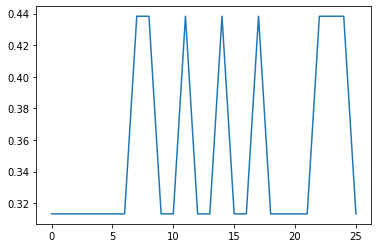

In [75]:
plt.plot(loss_list)

### 模型测试

 - 读取模型参数，输入时不输入标签，将得到的值取softmax即为模型预测出的标签，与label比较求准确率。同时由于该问题也可以看作信息检索问题，同时可以采用信息检索的指标如MAP、MRR
   - MAP：Mean Average Precision. MAP是AP的平均值。AP指的是在各个召回率上的正确率的平均值
   - MRR：是把标准答案在被评价系统给出结果中的排序取倒数作为它的准确度，再对所有的问题取平均

In [76]:
def AP(output,target):
    output = torch.tensor(output,dtype=torch.float)
    target = torch.tensor(target,dtype = torch.float)
    _,indexes = torch.sort(output,descending = True)
    target = target[indexes].round()
    total = 0.
    
    for i in range(len(output)):
        index = i+1
        if target[i]:
            total += target[:index].sum().item() / index
        # 如果没有正确答案， target.sum =0 出现异常
        return total / target.sum().item()
        # 没有正确答案返回0
    
def MAP(outputs, targets):
    assert(len(outputs) == len(targets))
    res =[]
    
    for i in range(len(outputs)):
        res.append(AP(outputs[i], targets[i]))
    return np.mean(res)

def RR(output,target):
    _,indexes = torch.sort(output,descending=True)
    best = target[indexes].nonzero().squeeze().min().item()
    return 1.0 / (best+1)

def MRR(outputs,targets):
    assert(len(outputs) == len(targets))
    res =[]
    for i in range(len(outputs)):
        res.append(RR(outputs[i] , targets[i]))
    return np.mean(res)

In [77]:
test_target = tokenize(test_file,max_length,tokenizer,device)

Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunction': True} not recognized.
Keyword arguments {'trunctio

In [78]:
# 创建Sampler
test_sampler = torch.utils.data.RandomSampler(test_target)

In [79]:
test_sampler

In [80]:
# 通过Dataset和Sampler创建dataloader
test_dataloader = torch.utils.data.DataLoader(test_target,sampler = test_sampler,batch_size = batch_size)

In [81]:
# 加载模型参数
model.load_state_dict(torch.load('./temp/best_param.bin'))

<All keys matched successfully>

In [88]:
tot_right = 0
tot = 0
y_hats =[]
y_gold =[]
result_path = "./result"
if not os.path.exists(result_path):
    os.makedirs(result_path)
result_file = open('./result/result.csv','w',encoding='utf-8')
for step,batch in enumerate(tqdm(test_dataloader)):
    all_zero = True
    for i in batch[3]:
        if i!=0:
            all_zero = False
            break
    if all_zero == True:
        continue
    
    model.eval()
    with torch.no_grad():
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'token_type_ids':batch[2]
        }
        
        y_hat = model(**inputs)
        y_hat = torch.argmax(y_hat, dim=1)
        y_wrt_list = [str(int(yh)) + '\n' for yh in y_hat.data]
        result_file.writelines(y_wrt_list)
        
        tot_right += (y_hat == batch[3]).sum()
        tot += len(batch[3])
        y_gold.append(batch[3])
        y_hats.append(y_hat)
print("Accuracy is {}".format(float(tot_right) / tot))
print("MAP is {}".format(MAP(y_hats,y_gold)))
print("MRR is {}".format(MRR(y_hats,y_gold)))
result_file.close()

  0%|          | 0/8 [00:00<?, ?it/s]

Accuracy is 0.8108108108108109
MAP is 0.0
MRR is 0.19238095238095237
